# Scikit-learn

scikit-learn è *la* libreria di machine learning in Python, il cui design ha influenzato moltissimi altri pacchetti. Ha anche un'ottima documentazione, con una quantità esaustiva di esempi e riferimenti teorici. Se dovete installarla, togliete il `#` ed eseguite la cella seguente.

In [1]:
# !pip install scikit-learn

## Piano delle lezioni

* Lezione 12 (oggi):
    - Introduzione all'interfaccia di sklearn: clustering, fitting e pipeline
* Lezione 13:
    - Analisi di alcune distanze per valutare il numero ottimale di cluster
* Lezione 14 e 15:
    - Regressioni logistiche
    - Metriche di errore
    - Cross-validation
    
## Clustering (1)

Iniziamo a conoscere la sintassi di scikit-learn applicando un KMeans clustering al dataset dei pinguini, per vedere in quanti cluster possiamo raggruppare i pinguini delle varie specie. Non si tratta esattamente di un'applicazione "a norma" del kmeans, che propriamente è un algoritmo di classificazione non-supervisionato, ma si tratta di un esercizio utile per vedere i limiti di questo approccio.

In [1]:
import pandas as pd

penguins = (
    pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv")
    .dropna()
)

penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


Iniziamo subito rimuovendo i valori nulli dal dataset. Il k-means non è disegnato per lavorare con variabili categoriche: per cui usiamo il metodo `pd.get_dummies` per trasformare le colonne `sex` e `island` in variabili dicotomiche (o dummies). In altre parole, la colonna `sex` con valori `male` e `female` viene trasformata in due colonne (`male` e `female`) che hanno rispettivamente valore 1 quando il pignuino è maschio e 0 quando è femmina, e viceversa.

In [2]:
penguins_unsupervised = (
    pd.get_dummies(
        penguins.filter([col for col in penguins.columns if "species" not in col]),
        columns=["sex", "island"]
    )
)

penguins_unsupervised.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,sex_female,sex_male,island_Biscoe,island_Dream,island_Torgersen
0,39.1,18.7,181.0,3750.0,2007,0,1,0,0,1
1,39.5,17.4,186.0,3800.0,2007,1,0,0,0,1
2,40.3,18.0,195.0,3250.0,2007,1,0,0,0,1
4,36.7,19.3,193.0,3450.0,2007,1,0,0,0,1
5,39.3,20.6,190.0,3650.0,2007,0,1,0,0,1


### Approfondimento

Nel caso di modelli statistici, l'approccio di creazione delle dummy spiegato qui sopra non va bene: il motivo è che le colonne `sex_female` e `sex_male` sono l'una *combinazione lineare* dell'altra. Questo significa che sono *perfettamente collineari* perché i valori di `sex_female` e `sex_male` si possono ottenere così:

`sex_female = 1 - sex_male`

Questa condizione si chiama multicollinearità e ha delle conseguenze statistiche che inficiano significativamente i nostri modelli. La soluzione ci viene già offerta da pandas: basta passare l'argomento `drop_first=True` al metodo `pd.get_dummies`.

In [3]:
penguins_unsupervised = (
    pd.get_dummies(
        penguins.filter([col for col in penguins.columns if "species" not in col]),
        columns=["sex", "island"],
        drop_first=True
    )
)

penguins_unsupervised.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,sex_male,island_Dream,island_Torgersen
0,39.1,18.7,181.0,3750.0,2007,1,0,1
1,39.5,17.4,186.0,3800.0,2007,0,0,1
2,40.3,18.0,195.0,3250.0,2007,0,0,1
4,36.7,19.3,193.0,3450.0,2007,0,0,1
5,39.3,20.6,190.0,3650.0,2007,1,0,1


Che cosa è cambiato? Praticamente quando creiamo le dummies ignoriamo uno dei *livelli* (non è importante quale scegliamo). In altre parole, una variabile categorica binaria (cioè con due livelli, ad esempio maschio-femmina) diventa una sola colonna (due livelli meno uno) fatta di 1 e 0; una categorica a tre livelli diventa due colonne di zeri e uno.

## KMeans

Per creare un modello in scikit-learn è sufficiente importare il relativo modulo e creare un'istanza del modello con i parametri che ci interessano:

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)

In questo caso, il nostro "oggetto" `kmeans` ha tre cluster e un `random_state` impostato in un valore casuale per assicurare che chiunque esegua il codice ottenga i nostri stessi risultati.

Dentro un jupyter notebook, chiamare gli oggetti di sklearn ci restituisce una piccola interfaccia interattiva per vederne i parametri (sarà più utile più avanti con oggetti più complessi):

In [7]:
kmeans

KMeans(n_clusters=3, random_state=42)

Per fittare il modello è sufficiente chiamare il metodo `fit` con i nostri dati:

In [6]:
kmeans_results = kmeans.fit(penguins_unsupervised)

L'oggetto `kmeans_results` ha diversi attributi che ci interessano. Il più interessante è il seguente, che possiamo "appiccicare" ai nostri dati originali per ottenere i cluster a cui viene assegnata ogni osservazione.

In [9]:
penguins["cluster"] = kmeans_results.labels_

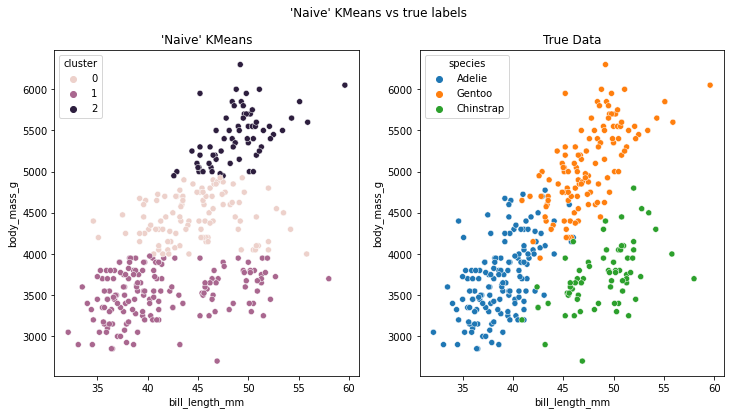

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.scatterplot(x="bill_length_mm", y="body_mass_g", hue="cluster", data=penguins, ax=ax[0])
sns.scatterplot(x="bill_length_mm", y="body_mass_g", hue="species", data=penguins, ax=ax[1])

ax[0].set(title="'Naive' KMeans")
ax[1].set(title="True Data")

fig.suptitle("'Naive' KMeans vs true labels")

plt.show()

Disegnare un grafico ci può aiutare a capire i cluster; in realtà però abbiamo eseguito l'algoritmo con molte più di due variabili (otto, esattamente): i cluster quindi sono stati disegnati in uno spazio con otto dimensioni e un grafico bidimensionale è un po' limitato. Tuttavia plottare il peso mostra chiaramente che il raggruppamento è dozzinale: sembra che avvenga solo a seconda del peso dei pinguini e non delle altre variabili. E infatti è quello che succede: il kmeans è un algoritmo sensibile alla scala delle misure dei dati. Guardiamo a come è fatto il nostro dataset:

In [16]:
penguins_unsupervised.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,sex_male,island_Dream,island_Torgersen
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057,2008.042042,0.504505,0.369369,0.141141
std,5.468668,1.969235,14.015765,805.215802,0.812944,0.500732,0.483360,0.348691
min,32.100000,13.100000,172.000000,2700.000000,2007.000000,0.000000,0.000000,0.000000
25%,39.500000,15.600000,190.000000,3550.000000,2007.000000,0.000000,0.000000,0.000000
50%,44.500000,17.300000,197.000000,4050.000000,2008.000000,1.000000,0.000000,0.000000
75%,48.600000,18.700000,213.000000,4775.000000,2009.000000,1.000000,1.000000,0.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000,1.000000,1.000000,1.000000


Viste le dimensioni di `body_mass_g` (che variano da 2700 a 6300), il kmeans è più sensibile alla variazione di quelle unità che a quella di altre, ad esempio se il sesso cambia da 0 a 1. Per risolvere questo problema dobbiamo normalizzare il dataset (sottrarre la media e dividere per la varianza). Il modo più efficace per farlo (ed evitare data leakages) è usare le `pipeline` di sklearn:

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    StandardScaler(),
    kmeans
)

pipeline_result = pipeline.fit(penguins_unsupervised)

In [22]:
penguins["pipeline_clusters"] = pipeline_result[1].labels_

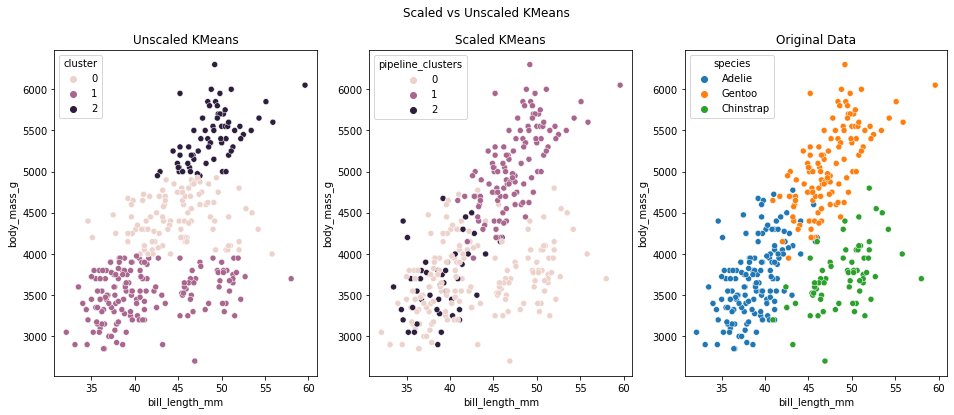

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(16,6))

sns.scatterplot(x="bill_length_mm", y="body_mass_g", hue="cluster", data=penguins, ax=ax[0])
sns.scatterplot(x="bill_length_mm", y="body_mass_g", hue="pipeline_clusters", data=penguins, ax=ax[1])
sns.scatterplot(x="bill_length_mm", y="body_mass_g", hue="species", data=penguins, ax=ax[2])

ax[0].set(title="Unscaled KMeans")
ax[1].set(title="Scaled KMeans")
ax[2].set(title="Original Data")

fig.suptitle("Scaled vs Unscaled KMeans")

plt.show()

La classificazione non è perfetta: non vengono distinte le classi di Adelie e Chinstrap, ma i Gentoo sono identificati in maniera sostanzialmente perfetta. Con un po' di feature engineering, si potrebbe migliorare la classificazione e distinguere ancora meglio i due cluster in fondo.